In [182]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [183]:
#!pip install matplotlib

In [184]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv') # 
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')

In [185]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [186]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [187]:
#df0 = df0.reset_index(drop=True)

In [188]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0,0.008226,0.008227,0.008154,0.008265,0.008108,0,0.008145,2950.0,0.008256,...,0.008193,0.008126,0,1,go_short,go_short,go_short,-0.646740,1467.702034,1482.297966
1,1,19.361000,19.849000,19.233614,19.095594,19.361000,0,19.775000,36000.0,19.051440,...,19.398400,19.295000,0,1,go_short,go_long,go_short,1.604684,18190.412919,17809.587081
2,2,509.570000,511.390000,515.329202,518.178371,470.010000,1,493.860000,588984.0,518.183600,...,512.976000,516.187143,1,0,go_long,go_long,go_short,-0.414138,289881.345226,299102.654774
3,3,2.377000,2.377000,2.437302,2.448547,2.377000,1,2.377000,1262.0,2.446520,...,2.429800,2.433571,1,1,go_short,go_short,go_short,-0.416108,631.000000,631.000000
4,4,0.022900,0.022940,0.022707,0.022787,0.022800,0,0.022930,822.0,0.022767,...,0.022736,0.022663,0,1,go_short,go_short,go_short,-0.077045,411.269038,410.730962


In [189]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [190]:
df0['action'].value_counts()

action
go_short    1562
go_long       92
Name: count, dtype: int64

In [191]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [192]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [193]:
train_data = df0 #prep_data(df0)

In [194]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,...,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward,ask,bid
0,0.008226,0.008227,0.008154,0.008265,0.008108,0,0.008145,2950.0,0.008256,1,...,0.008193,0.008126,0,1,go_short,go_short,go_short,-0.646740,1467.702034,1482.297966
1,19.361000,19.849000,19.233614,19.095594,19.361000,0,19.775000,36000.0,19.051440,0,...,19.398400,19.295000,0,1,go_short,go_long,go_short,1.604684,18190.412919,17809.587081


In [195]:
new_cols = ['ask','bid','sma-compare','is_short']

In [196]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [197]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [198]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [199]:
Hyperparameters = [
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000]



]

#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[22] #Hyperparameters[6]



In [200]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [201]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   0%|          | 25/8000 [00:00<01:47, 74.38it/s]

Episode 0/8000 - Total Reward: -628.3339823899997, Epsilon: 0.997


evaluating results per episode ...:   5%|▌         | 413/8000 [00:04<01:15, 100.47it/s]

Episode 400/8000 - Total Reward: -519.4211300499996, Epsilon: 0.997


evaluating results per episode ...:  10%|█         | 817/8000 [00:09<01:31, 78.41it/s] 

Episode 800/8000 - Total Reward: -641.4388220399995, Epsilon: 0.997


evaluating results per episode ...:  15%|█▌        | 1211/8000 [00:13<01:17, 88.07it/s] 

Episode 1200/8000 - Total Reward: -184.37053629999951, Epsilon: 0.997


evaluating results per episode ...:  20%|██        | 1609/8000 [00:17<00:58, 109.59it/s]

Episode 1600/8000 - Total Reward: -602.6100481799996, Epsilon: 0.997


evaluating results per episode ...:  25%|██▌       | 2011/8000 [00:21<01:07, 88.61it/s] 

Episode 2000/8000 - Total Reward: -390.4742953800001, Epsilon: 0.997


evaluating results per episode ...:  30%|███       | 2437/8000 [00:24<00:31, 177.52it/s]

Episode 2400/8000 - Total Reward: -573.3390200999999, Epsilon: 0.997


evaluating results per episode ...:  35%|███▌      | 2833/8000 [00:26<00:46, 110.91it/s]

Episode 2800/8000 - Total Reward: -193.53019301999956, Epsilon: 0.997


evaluating results per episode ...:  40%|████      | 3211/8000 [00:31<00:54, 87.64it/s] 

Episode 3200/8000 - Total Reward: -311.5434456899998, Epsilon: 0.997


evaluating results per episode ...:  45%|████▌     | 3634/8000 [00:34<00:25, 173.72it/s]

Episode 3600/8000 - Total Reward: -341.26038986000003, Epsilon: 0.997


evaluating results per episode ...:  50%|█████     | 4015/8000 [00:36<00:34, 114.19it/s]

Episode 4000/8000 - Total Reward: -584.9028719499996, Epsilon: 0.997


evaluating results per episode ...:  55%|█████▌    | 4424/8000 [00:39<00:34, 102.47it/s]

Episode 4400/8000 - Total Reward: -209.75194306999956, Epsilon: 0.997


evaluating results per episode ...:  60%|██████    | 4815/8000 [00:44<00:34, 91.48it/s] 

Episode 4800/8000 - Total Reward: -702.1344483499996, Epsilon: 0.997


evaluating results per episode ...:  65%|██████▌   | 5219/8000 [00:48<00:29, 94.32it/s] 

Episode 5200/8000 - Total Reward: -526.2630790699995, Epsilon: 0.997


evaluating results per episode ...:  70%|███████   | 5616/8000 [00:53<00:26, 89.55it/s]

Episode 5600/8000 - Total Reward: -321.8498486700001, Epsilon: 0.997


evaluating results per episode ...:  75%|███████▌  | 6015/8000 [00:57<00:22, 88.12it/s] 

Episode 6000/8000 - Total Reward: -685.9030332199999, Epsilon: 0.997


evaluating results per episode ...:  81%|████████  | 6442/8000 [01:00<00:08, 194.42it/s]

Episode 6400/8000 - Total Reward: -461.7562546999994, Epsilon: 0.997


evaluating results per episode ...:  85%|████████▌ | 6820/8000 [01:02<00:07, 168.08it/s]

Episode 6800/8000 - Total Reward: -455.6947706999994, Epsilon: 0.997


evaluating results per episode ...:  90%|█████████ | 7228/8000 [01:05<00:04, 187.20it/s]

Episode 7200/8000 - Total Reward: -693.0957064499997, Epsilon: 0.997


evaluating results per episode ...:  95%|█████████▌| 7639/8000 [01:07<00:01, 192.44it/s]

Episode 7600/8000 - Total Reward: -344.3817512300002, Epsilon: 0.997


evaluating results per episode ...: 100%|██████████| 8000/8000 [01:09<00:00, 115.78it/s]


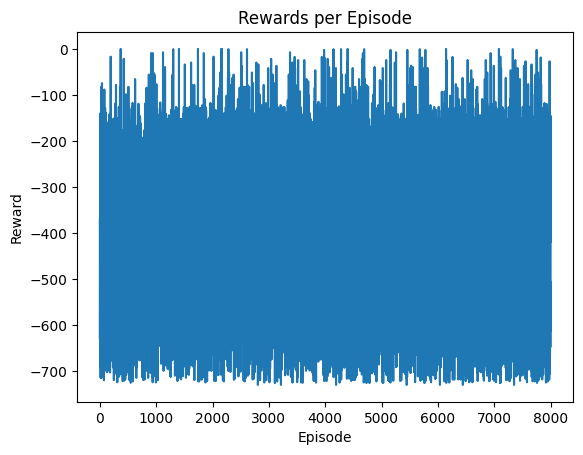

In [202]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [203]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [204]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [205]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [206]:
# Predict an entire range
def predict_range(df: DataFrame = train_data) -> DataFrame:
    for idx, row in df.iterrows():
        state = row[['ask','bid','sma-compare', 'is_short']].values
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

In [207]:
train_data = predict_range(train_data)

In [208]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       776
go_short      441
do_nothing    437
Name: count, dtype: int64

In [209]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
1    476
0     28
Name: count, dtype: int64

In [210]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

28
476


In [211]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/1653
Current Predicted Reward: 0
Current Actual Reward: 1.60468371
Processed state 100/1653
Current Predicted Reward: -19.60146686
Current Actual Reward: 5.025142020000005
Processed state 200/1653
Current Predicted Reward: -0.5352487999999951
Current Actual Reward: 51.13514048000001
Processed state 300/1653
Current Predicted Reward: 14.234027800000003
Current Actual Reward: 92.10219480999999
Processed state 400/1653
Current Predicted Reward: 32.208698649999995
Current Actual Reward: 148.58002513000002
Processed state 500/1653
Current Predicted Reward: 44.10237406999999
Current Actual Reward: 195.49077047999992
Processed state 600/1653
Current Predicted Reward: 55.505094490000005
Current Actual Reward: 234.70390918999996
Processed state 700/1653
Current Predicted Reward: 71.2928852
Current Actual Reward: 282.2080611299999
Processed state 800/1653
Current Predicted Reward: 85.12260544999995
Current Actual Reward: 322.5742968900001
Processed state 900/1653
Current Predic

In [212]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 27.93%


In [213]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 44  19  19]
 [728 418 426]
 [  0   0   0]]


In [214]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP*100/n_states

In [215]:
#con_acc = confusion_accuracy(cm, n_states=n_states)
#print(f"confusion accuracy: {con_acc:.2f}%")

In [216]:
df0['predicted_action'].value_counts()

predicted_action
go_long       776
go_short      441
do_nothing    437
Name: count, dtype: int64

In [217]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] != f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%'
    }

In [218]:
print(action_reward('go_short', 0)) # go_short 1

{'counts': 72, 'total': 16.43752514999998, 'winrate': '63.89%'}


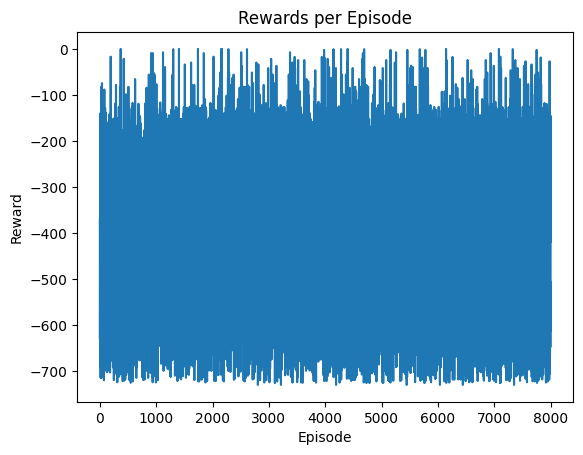

In [219]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [220]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [221]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [222]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [223]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [224]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        